In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import torch.nn.functional as F
import torch

from common import metrics

In [115]:
bs = 128
wl = 1024
winsize = 12
signals = torch.rand(bs, wl)
gt_labels = (torch.rand_like(signals) > 0.7).to(torch.int)

n_t = 100


def cm_win():
    fp, fn, th = metrics.errors_curve(signals, gt_labels, winsize, n_t)
    metrics.plot_errors_curve(fp, fn, th)

In [116]:
%%timeit
fp, fn, th = metrics.errors_curve(signals, gt_labels, winsize, 10)

54.4 ms ± 677 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


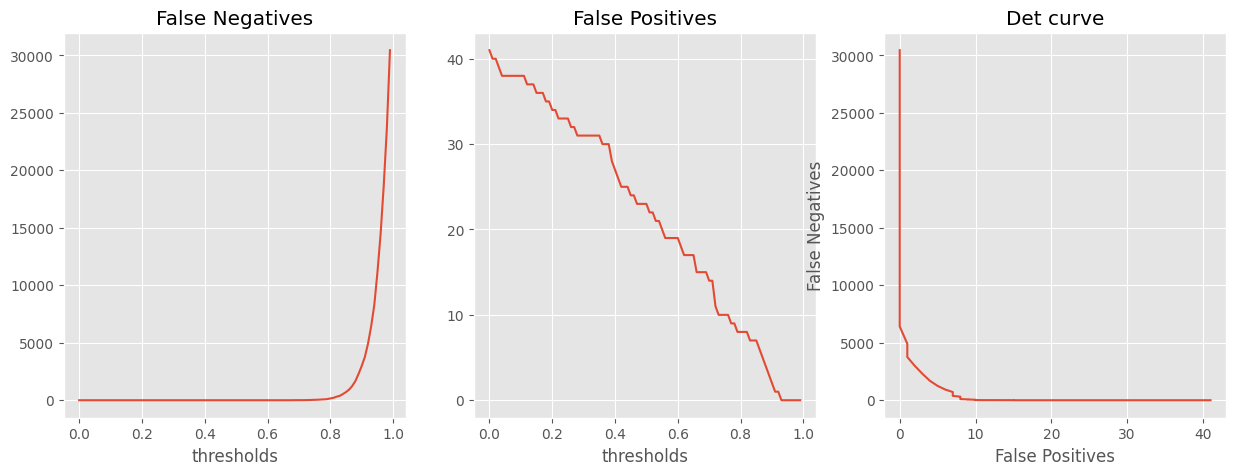

In [117]:
cm_win()